<a href="https://colab.research.google.com/github/bhadreshpsavani/HuggingfaceModelTraining/blob/main/SentimentDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Negative Sentiment Analysis

The problem is to build and test a model that will predict the tone (neutral or negative) of the text message. To do this, you will need to train the model on the data provided. The resulting model has to predict the class (neutral or negative) and test results reported on test data that was not used to train the model. An ideal model should not miss predicting a negative tone in the message text.

## Steps:
  1. Import Data
  2. Data Analysis
  3. EDA on the data
  4. Choice of model
  5. Choice of evaluation metric
  6. Accuracy of the model
  7. Summary and analysis of the results … Where does the model fail? How would you improve predictions in future?

## Step1. Import Data

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('data.csv')
df.head()

,textID,text,sentiment
0,2a0463352b,that`s enough! I`ll do nothing for 2 hours.,neutral
1,f358968122,I have to go clothes shopping tomorrow I hate...,negative
2,449e7733f1,i am bored. :| any idea`s of a nice site?,neutral
3,6099baf6e8,I don`t think will want to come back (guys r...,negative
4,f946da7a04,_thomas if only the drinking game was tonight....,neutral


## Step2. Data Analysis:

In [4]:
df.sentiment.value_counts(normalize=True)

neutral     0.591517
negative    0.408483
Name: sentiment, dtype: float64

Observation: Our data is slighly imbalanced

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11955 entries, 0 to 11954
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     11955 non-null  object
 1   text       11954 non-null  object
 2   sentiment  11954 non-null  object
dtypes: object(3)
memory usage: 280.3+ KB


According to above results, We have null value in `text` column which needs to be removed

In [6]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11953 entries, 0 to 11953
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     11953 non-null  object
 1   text       11953 non-null  object
 2   sentiment  11953 non-null  object
dtypes: object(3)
memory usage: 373.5+ KB


In [7]:
for i, text in enumerate(df.text[:20]):
  print(i+1, ":",  text)
  print()

1 : that`s enough! I`ll do nothing for 2 hours.

2 : I have to go clothes shopping tomorrow  I hate it, but I have a serious 'clothes falling apart' situation here.

3 : i am bored. :| any idea`s of a nice site?

4 : I don`t think  will want to come back  (guys read your dms)

5 : _thomas if only the drinking game was tonight...I don`t have to work till 5 tomorrow

6 : my birthday is in 2 days

7 : I wish the sun would come out...I guess it doesn`t matter since I`m at work and can`t enjoy it anyways

8 : I am very sad because I have gone on the show McFly fan I am of them!

9 : no one ever gave me the info I`m sad

10 : all tubes closed on 9th and 10th of june  any idea of how to get to the venue?

11 : ****...plans were canceled.....another friday night at home

12 :  always write holy words in capital dude, ALLAH HAFIZ !

13 :  Dang! Of course, I`m just jealous `cuz I didn`t think of it first

14 : yay!! we`ll all move!! sorry dh is being Grr...  ****

15 : I had my hair cut today an

Observation: We need to clean up our text data. It's having `:|` or `****` kind of item which will not be very effective to train an ML model

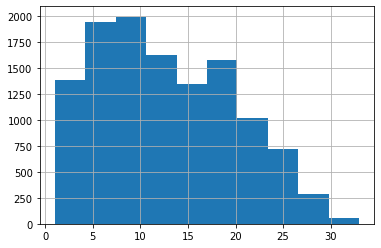

In [16]:
df["number_of_words"] = df.text.apply(lambda txt: len(txt.split()))
df["number_of_words"].hist()

In [17]:
df["number_of_words"].value_counts(normalize=True)

8     0.057726
7     0.057140
9     0.055802
10    0.053376
6     0.053041
5     0.052455
4     0.050950
12    0.047603
11    0.046516
13    0.041914
14    0.040576
15    0.037145
3     0.036476
16    0.034803
17    0.033632
20    0.033548
19    0.032628
18    0.032293
21    0.031708
22    0.027357
23    0.025851
24    0.023174
25    0.022839
2     0.019493
26    0.014641
27    0.011127
28    0.009286
1     0.008868
29    0.003597
30    0.002593
31    0.001339
32    0.000418
33    0.000084
Name: number_of_words, dtype: float64

In [18]:
df.query("number_of_words<=1")

,textID,text,sentiment,number_of_words
60,823122597e,mean,neutral,1
194,47990d2312,BRAINFREEZE,neutral,1
288,397392f0d9,WORD!!!!!,neutral,1
323,25ddc5bea5,ruilen?,neutral,1
634,4f91f17179,boo,neutral,1
...,...,...,...,...
11541,3c8698c64b,yup,neutral,1
11558,65a9dd6348,byeeeee,neutral,1
11570,50f5c4bba5,upgraded,neutral,1
11577,044c845832,yes,neutral,1


Our data is having `www.youtube.com/watch?v=9FtuV3xMrN0` kind of text, we can't ignore/ remove such data. It doesn't convery much  but when user enters such data model should be able to handle such cases and correctly classify them. 

## Create Train and Test Data:

In [19]:
sentimental_data = df[['text', 'sentiment']]

In [20]:
# to evenly divide train and test dataset
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(sentimental_data, sentimental_data["sentiment"]):
    strat_train_set = sentimental_data.iloc[train_index]
    strat_test_set = sentimental_data.iloc[test_index]

In [21]:
sentimental_data.sentiment.value_counts(normalize=True)

neutral     0.591483
negative    0.408517
Name: sentiment, dtype: float64

In [22]:
strat_train_set.sentiment.value_counts(normalize=True)

neutral     0.591508
negative    0.408492
Name: sentiment, dtype: float64

In [23]:
strat_test_set.sentiment.value_counts(normalize=True)

neutral     0.591384
negative    0.408616
Name: sentiment, dtype: float64

In [24]:
strat_train_set.columns = ['sentence1', 'label']
strat_test_set.columns = ['sentence1', 'label']

In [25]:
strat_train_set.head()

,sentence1,label
1635,owww i think i tore something in my leg,negative
10580,Hi how are you doing ??? *just joined twitte...,neutral
4696,off to go buy more deck sleeves and 3X3 card p...,negative
6458,You really are always dirty!!! Ha ha!!!! Do yo...,negative
1172,got **** stranger lol,neutral


In [26]:
strat_train_set.to_csv("train.csv", index=False)
strat_test_set.to_csv("val.csv", index=False)

We divided data in training and testset with equal labeling distribution

## Choice of model:

We will choose transformer based model like bert, roberta for training. Based on various experiments. According to Experiments done on https://github.com/bentrevett/pytorch-seq2seq on Setimental Analysis task Attention based model like Bert Provide better results on this task

In [27]:
!git clone  https://github.com/huggingface/transformers.git
%cd transformers
!pip install -q .
!pip install -q -r ./examples/tensorflow/text-classification/requirements.txt

Cloning into 'transformers'...
remote: Enumerating objects: 72060, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 72060 (delta 24), reused 41 (delta 11), pack-reused 71974
Receiving objects: 100% (72060/72060), 54.76 MiB | 29.10 MiB/s, done.
Resolving deltas: 100% (51165/51165), done.
/content/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3MB 9.9MB/s 
     |████████████████████████████████| 901kB 51.3MB/s 
     |████████████████████████████████| 225kB 9.9MB/s 
     |████████████████████████████████| 1.2MB 17.7MB/s 
     |████████████████████████████████| 245kB 48.5MB/s 
     |████████████████████████████████| 112kB 49.5MB/s 


In [28]:
%cd ..

/content


In [30]:
!python transformers/examples/tensorflow/text-classification/run_text_classification.py \
--model_name_or_path distilbert-base-cased \
--train_file train.csv \
--validation_file val.csv \
--max_seq_length 64 \
--per_device_train_batch_size 32 \
--per_device_eval_batch_size 32 \
--output_dir output/ \

2021-05-08 14:20:41.133956: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
05/08/2021 14:20:42 - INFO - __main__ -   Training/evaluation parameters TFTrainingArguments(output_dir='output/', overwrite_output_dir=False, do_train=False, do_eval=False, do_predict=False, evaluation_strategy=<IntervalStrategy.NO: 'no'>, prediction_loss_only=False, per_device_train_batch_size=32, per_device_eval_batch_size=32, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, eval_accumulation_steps=None, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3.0, max_steps=-1, lr_scheduler_type=<SchedulerType.LINEAR: 'linear'>, warmup_ratio=0.0, warmup_steps=0, logging_dir='runs/May08_14-20-42_46ba2ec0e02c', logging_strategy=<IntervalStrategy.STEPS: 'steps'>, logging_first_step=False, logging_steps=500, save_strategy=<Interv